# Overview of the Gradient Boosted Tree Classifier

Gradient Boosting is an ensemble learning method that takes many weak learners (with accuracy slightly above that of a random guess) and combines them sequentially to create a strong learner (model accuracy of >95%).

Advantages:
- Highly interpretable - the steps are intuitive
- Versatile - can be used for both classification and regression problems

Disadvantages:
- If the hyperparameters aren't tuned carefully, it is easy for the model to overfit the training data
- The model can become computationally expensive, as it requires subsequently training multiple weak learners

### Representation

We have chosen to implement Gradient Boosting for a classification problem, using a shallow decision tree as our weak learner. The final model $F(x)$ is therefore built from a sequence of $N$ trees, where each successive tree corrects the predictions from the previous iteration:

$F_{N}(x) = F_{0}(x) + \eta \sum_{i=1}^{N} h_{i}(x)$ 

Where:
- $F_{0}(x)$ is the initial prediction
- $\eta$ is the learning rate (a value between 0 and 1)
- $h_{i}(x)$ is the prediction made by decision tree $i$, trained on the residuals from the previous trees

We are not predicting class labels, but are instead predicting pseudo-residuals that will be used to correct the initial prediction.

### Loss

As this is a binary classification problem we will be using the Cross-Entropy loss/Log loss as our loss function. The function is:

$L(y, \hat{p}(x)) = -(y \cdot log(\hat{p}(x)) + (1-y) \cdot log(1-\hat{p}(x)))$

Where:
- $y$ are the true labels, 1 or 0
- $\hat{p}(x)$ is the probability predictor for the positive class, 1

### Optimizer

The optimizer is gradient descent on the pseudo-residuals

We calculate the pseudo-residuals as the negative gradient of the loss function with respect to the current model prediction:

$r_i = -\frac{\partial L(y, \hat{p}(x))}{\partial F(x)} = y - \hat{p}(x)$

Shallow decision trees are trained on the previous iteration residuals, which are then used to update the prediction

$F_{i+1}(x) = F_{i}(x) + \eta \cdot h_{i}(x)$ 

### Algorithm Pseudocode

**inputs:**

*training set:* $S = (x_1, y_1), ... , (x_m, y_m)$

*weak learner: decision tree classifier* $DTC$

*number of trees:* $N$

*learning rate:* $\eta$

**initialize:**

*set initial predictions as log-odds of the positive class:* $F_{0}(x) = logit(p_{y=1}) = log(\frac{p_{y=1}}{1-p_{y=1}})$ 

**for** $i = 0, ...,N-1:$

*compute the residuals:* $r_i = -\frac{\partial L(y, \hat{p}_{i}(x))}{\partial F_{i}(x)} = y - \hat{p}_{i}(x)$

*train a weak learner with residuals as targets:* $h_{i}(x) = DTC(F_{i}(x), S)$

*update the model:* $F_{i+1}(x) = F_{i}(x) + \eta \cdot h_{i}(x)$

**output:** 

*the predictions* $\hat{y} = argmax(F_{N}(x))$


# Model

In [37]:
import numpy as np
import math

def sigmoid(x):
    '''
        Sigmoid function f(x) =  1/(1 + exp(-x))
        :param x: A scalar or Numpy array
        :return: Sigmoid function evaluated at x (applied element-wise if it is an array)
    '''
    return np.where(x > 0, 1 / (1 + np.exp(-x)), np.exp(x) / (np.exp(x) + np.exp(0)))

### Weak Learner: Decision Tree

In [38]:
def node_score_entropy(prob): 
    # C(p) = -p * log(p) - (1-p) * log(1-p)
    if prob >= 1:
        score = 0
    else:
        if prob <= 0:
            score = 0
        else:
            score = -prob*math.log(prob)-(1-prob)*math.log(1-prob)
        
    return score

class Node:
    def __init__(self, left=None, right=None, depth=0, index_split_on=0, isleaf=False, label=1):
        self.left = left
        self.right = right
        self.depth = depth
        self.index_split_on = index_split_on
        self.isleaf = isleaf
        self.label = label
        self.info = {} # used for visualization


    def _set_info(self, gain, num_samples):
        self.info['gain'] = gain
        self.info['num_samples'] = num_samples

class DecisionTree:

    def __init__(self, data, validation_data=None, gain_function=node_score_entropy, max_depth=40):

        # TODO: find majority class; set to class 0 if exactly balanced. This is the default label of your root node.
        # Make sure to assign it to an instance variable `majority_class`.

        y = [row[0] for row in data]  # Assuming the first column contains labels
        class_counts = {0: y.count(0), 1: y.count(1)}
        
        # Set majority class (default label of the root node)
        if class_counts[0] >= class_counts[1]:
            self.majority_class = 0
        else:
            self.majority_class = 1
            
        self.max_depth = max_depth
        self.root = Node(label = self.majority_class)
        self.gain_function = gain_function

        indices = list(range(1, len(data[0])))

        self._split_recurs(self.root, data, indices)

        # Pruning
        if validation_data is not None:
            self._prune_recurs(self.root, validation_data)


    def predict(self, features):
        '''
        Helper function to predict the label given a row of features.
        You do not need to modify this.
        '''
        return self._predict_recurs(self.root, features)


    def accuracy(self, data):
        '''
        Helper function to calculate the accuracy on the given data.
        You do not need to modify this.
        '''
        return 1 - self.loss(data)


    def loss(self, data):
        '''
        Helper function to calculate the loss on the given data.
        You do not need to modify this.
        '''
        cnt = 0.0
        test_Y = [row[0] for row in data]
        for i in range(len(data)):
            prediction = self.predict(data[i])
            if (prediction != test_Y[i]):
                cnt += 1.0
        return cnt/len(data)


    def _predict_recurs(self, node, row):
        '''
        Helper function to predict the label given a row of features.
        Traverse the tree until leaves to get the label.
        You do not need to modify this.
        '''
        if node.isleaf or node.index_split_on == 0:
            return node.label
        split_index = node.index_split_on
        if not row[split_index]:
            return self._predict_recurs(node.left, row)
        else:
            return self._predict_recurs(node.right, row)


    def _prune_recurs(self, node, validation_data):
        '''
        TODO:
        Prune the tree bottom up recursively. Nothing needs to be returned.
        Do not prune if the node is a leaf.
        Do not prune if the node is non-leaf and has at least one non-leaf child.
        Prune if deleting the node could reduce loss on the validation data.
        NOTE:
        This might be slightly different from the pruning described in lecture.
        Here we won't consider pruning a node's parent if we don't prune the node 
        itself (i.e. we will only prune nodes that have two leaves as children.)
        HINT: Think about what variables need to be set when pruning a node!
        '''
        # Checks if node is not a Leaf
        if not node.isleaf:
            if node.left is not None:
                self._prune_recurs(node.left, validation_data)
                pass
                
            if node.right is not None:
                self._prune_recurs(node.right, validation_data)
                pass
                
            if (node.left.isleaf) and (node.right.isleaf):
                # Calculate the loss before pruning
                original_loss = self.loss(validation_data)
                
                # Temporarily prune this node (convert to leaf)
                original_left, original_right = node.left, node.right
                node.isleaf = True
                node.left, node.right = None, None
                
                # Calculate the loss after pruning
                pruned_loss = self.loss(validation_data)
                
                # If pruning doesn't reduce the loss, revert the pruning
                if pruned_loss > original_loss:
                    node.isleaf = False
                    node.left, node.right = original_left, original_right

        return
                    
        
    def _is_terminal(self, node, data, indices):
        '''
        TODO:
        Helper function to determine whether the node should stop splitting.
        Stop the recursion if:
            1. The dataset (as passed to parameter data) is empty.
            2. There are no more indices to split on.
            3. All the instances in this dataset belong to the same class
            4. The depth of the node reaches the maximum depth.
        Set the node label to be the majority label of the training dataset if:
            1. The number of class 1 points is equal to the number of class 0 points.
            2. The dataset is empty.
        Return:
            - A boolean, True indicating the current node should be a leaf and 
              False if the node is not a leaf.
            - A label, indicating the label of the leaf (or the label the node would 
              be if we were to terminate at that node). If there is no data left, you
              must return the majority class of the training set.
        '''
        y = [row[0] for row in data]        
        
        # TODO: Check Cases if the node should stop splitting
        # TODO: Check cases if the node should be set to the majority label of the training dataset

        node.isleaf = False
        
        if y.count(1)>y.count(0):
            node.label = True
        else:
            if y.count(1)==y.count(0):
                node.label = self.majority_class
            else:
                node.label = False
                    
        # the dataset is empty
        if len(y) == 0:
            node.isleaf = True
            node.label = self.majority_class 
        
        # there are no more indices to split on
        if len(indices)==0:
            node.isleaf = True

        # all the instances in this dataset belong to the same class
        if len(set(y))==1:
            node.isleaf = True
            if y.count(1)>0:
                node.label = True
            else:
                node.label = False

        # the depth of the node reaches the maximum depth
        if (node.depth == self.max_depth):
            node.isleaf = True
        
        return (node.isleaf, node.label)

    def _split_recurs(self, node, data, indices):
        '''
        TODO:
        Recursively split the node based on the rows and indices given.
        Nothing needs to be returned.

        First use _is_terminal() to check if the node needs to be split.
        If so, select the column that has the maximum infomation gain to split on.
        Store the label predicted for this node, the split column, and use _set_info()
        to keep track of the gain and the number of datapoints at the split.
        Then, split the data based on its value in the selected column.
        The data should be recursively passed to the children.
        '''
        node.isleaf, node.label = self._is_terminal(node, data, indices)
        
        if not node.isleaf:
            # TODO: Initialize and Calculate Gain
            idx_max = 0
            gain_max = 0
            
            for idx in indices:
                gain = self._calc_gain(data, idx, self.gain_function)
                if gain > gain_max:
                    gain_max = gain
                    idx_max = idx
                
            # TODO: Split the column and use _set_info() 

            if gain_max == 0:
                node.isleaf = True
                return

            else:
                split_index = idx_max
                node.index_split_on = split_index
                node._set_info(gain_max, len(data))
                indices.remove(idx_max)
                        
            # TODO: Split the Data and Pass it recursively to the  children
            best_left = [row for row in data if not row[split_index]]
            best_right = [row for row in data if row[split_index]]
            left_child = Node(depth=node.depth + 1, label=self.majority_class)
            right_child = Node(depth=node.depth + 1, label=self.majority_class)
            
            node.left = left_child
            node.right = right_child
            
            self._split_recurs(left_child, best_left, indices)
            self._split_recurs(right_child, best_right, indices)
            
        return
            
    def _calc_gain(self, data, split_index, gain_function):
        '''
        TODO:
        Calculate the gain of the proposed splitting and return it.
        Gain = C(P[y=1]) - P[x_i=True] * C(P[y=1|x_i=True]) - P[x_i=False] * C(P[y=0|x_i=False])
        Here the C(p) is the gain_function. For example, if C(p) = min(p, 1-p), this would be
        considering training error gain. Other alternatives are entropy and gini functions.
        '''
        
        y = [row[0] for row in data]
        xi = [row[split_index] for row in data]
        
        if len(y) != 0 and len(xi) != 0:

            prob_y = np.sum(y)/len(y)
            prob_x = np.sum(xi)/len(xi)

            y_true = np.array([])
            y_false = np.array([])
            
            for j in range(len(y)):
                if xi[j] == True:
                   y_true = np.append(y_true,y[j]) 
                else:
                   y_false = np.append(y_false, y[j]) 

            if len(y_true) != 0:
                
                prob_y_true = np.sum(y_true)/len(y_true)
            else:
                prob_y_true = 0

            if len(y_false) !=0:
                prob_y_false = 1-np.sum(y_false)/len(y_false)
            else:
                prob_y_false = 0
                
            gain = gain_function(prob_y)-prob_x*gain_function(prob_y_true)-(1-prob_x)*gain_function(prob_y_false) 
        else:
            gain = 0

        return gain
    
    def print_tree(self):
        '''
        Helper function for tree_visualization.
        Only effective with very shallow trees.
        You do not need to modify this.
        '''
        print('---START PRINT TREE---')
        def print_subtree(node, indent=''):
            if node is None:
                return str("None")
            if node.isleaf:
                return str(node.label)
            else:
                decision = 'split attribute = {:d}; gain = {:f}; number of samples = {:d}'.format(node.index_split_on, node.info['gain'], node.info['num_samples'])
            left = indent + '0 -> '+ print_subtree(node.left, indent + '\t\t')
            right = indent + '1 -> '+ print_subtree(node.right, indent + '\t\t')
            return (decision + '\n' + left + '\n' + right)

        print(print_subtree(self.root))
        print('----END PRINT TREE---')


    def loss_plot_vec(self, data):
        '''
        Helper function to visualize the loss when the tree expands.
        You do not need to modify this.
        '''
        self._loss_plot_recurs(self.root, data, 0)
        loss_vec = []
        q = [self.root]
        num_correct = 0
        while len(q) > 0:
            node = q.pop(0)
            num_correct = num_correct + node.info['curr_num_correct']
            loss_vec.append(num_correct)
            if node.left != None:
                q.append(node.left)
            if node.right != None:
                q.append(node.right)

        return 1 - np.array(loss_vec)/len(data)


    def _loss_plot_recurs(self, node, rows, prev_num_correct):
        '''
        Helper function to visualize the loss when the tree expands.
        You do not need to modify this.
        '''
        labels = [row[0] for row in rows]
        curr_num_correct = labels.count(node.label) - prev_num_correct
        node.info['curr_num_correct'] = curr_num_correct

        if not node.isleaf:
            left_data, right_data = [], []
            left_num_correct, right_num_correct = 0, 0
            for row in rows:
                if not row[node.index_split_on]:
                    left_data.append(row)
                else:
                    right_data.append(row)

            left_labels = [row[0] for row in left_data]
            left_num_correct = left_labels.count(node.label)
            right_labels = [row[0] for row in right_data]
            right_num_correct = right_labels.count(node.label)

            if node.left != None:
                self._loss_plot_recurs(node.left, left_data, left_num_correct)
            if node.right != None:
                self._loss_plot_recurs(node.right, right_data, right_num_correct)

### Gradient Boosting

In [114]:
class GBDTC:
    def __init__(self, n_estimators=2, learning_rate=0.1, max_depth=3):
        self.n_estimators=n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.tree_list = []
        self.F_list = []
        self.init_val = None

    def train(self, X, y):
        # X: feature vectors 2D numpy array (row: # of data / column: # of features)
        # y: label vectors (binary) 

        # Initial guess
        self.init_val = np.log(np.mean(y) / (1 - np.mean(y)))
        F = np.full(len(y), self.init_val)

        # Iteration for the number of estimators
        for i in range(self.n_estimators):
            prob = sigmoid(F)
            
            residuals = y-prob
            # Train a weak learner (decision tree) to the residuals
            data_residuals = np.hstack((residuals.reshape(-1,1), X))
            tree = DecisionTree(data_residuals, gain_function=node_score_entropy, max_depth=self.max_depth)
            self.tree_list.append(tree)
            
            for i, x in enumerate(X):
                pred = tree.predict(x) # predict the y(label) for each data
                F[i] += self.learning_rate * pred

    def predict(self, X):
        # X: feature vectors 2D numpy array (row: # of data / column: # of features)
        F = np.full(X.shape[0], self.init_val)  # Start with the initial prediction
        for tree in self.tree_list:
            for i, x in enumerate(X):
                pred = tree.predict(x) # predict the y(label) for each data of current tree
                F[i] += self.learning_rate * pred

        y_pred = (F>=0.5).astype(int)
        return y_pred

    def score(self, X, y):
        # Calculate the score of the model with the dataset, corresponding to the GradientBoostingClassifier.score method
        y_pred = self.predict(X)
        mean_accuracy = (y_pred==y).sum()/len(y)

        return mean_accuracy

In [120]:
X_train = np.array([[1,0,0],[0,1,1],[1,0,1],[0,1,0],[1,1,1],[0,0,0]])
y_train = np.array([0,1,1,0,0,0])

X_test = np.array([[0,1,0],[1,1,1]])
y_test = np.array([1,1])

model = GBDTC(n_estimators=2, learning_rate=0.1, max_depth=3)

model.train(X_train,y_train)
model.predict(X_test)
model.score(X_test,y_test)

(6,)


np.float64(1.0)

# Check Model

In [131]:
# Use a scikit-learn GradientBoostingClassifier as an reference
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

X, y = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

clf = GradientBoostingClassifier(n_estimators=6, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.6553

In [123]:
# Preprocessing for y_data
y_train[y_train==-1] = 0
y_test[y_test==-1] = 0

In [127]:
clf_compare = GBDTC(n_estimators=5, learning_rate=1.0, max_depth=1)
clf_compare.train(X_train,y_train)
clf_compare.score(X_test,y_test)

(2000,)


np.float64(0.5049)

### Iris Dataset

Model accuracy: 1.0


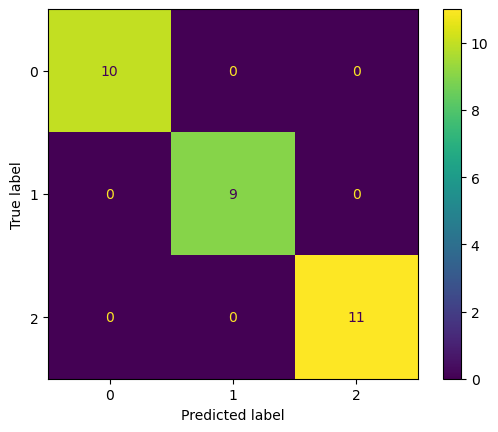

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
 
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
 
# Divide the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Create a CART template
tree_classifier = DecisionTreeClassifier(random_state=42)
 
#Train the model on the training data
tree_classifier.fit(X_train, y_train)

#Make predictions on test data
y_pred = tree_classifier.predict(X_test)
 
#Calculate the accuracy of the model<code>
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy:", accuracy)
 
#View the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=tree_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=tree_classifier.classes_)
disp.plot()
